In [1]:
# --------------- Instalar Libs no Jupyter --------------- #
# pip install opencv-python
# pip install tensorflow

In [2]:
# Lib para acessar recursos do sistema operacional
import os
# Lib para trabalhar com imagens
import cv2
# Lib para matrizes
import numpy as np
# Lib para gráficos
import matplotlib.pyplot as plt
# Lib para gráficos
import seaborn as sns

# Lib para Machine Learning
import tensorflow as tf
# Função das camadas e pesos da rede neural
from tensorflow.keras import layers, optimizers
# Função para criar a rede convolucional
from tensorflow.keras.applications import ResNet50
# Função para as camadas da Rede Neurak
from tensorflow.keras.layers import Input, Dense, AveragePooling2D, Dropout, Flatten
# Função para criar a rede neural
from tensorflow.keras.models import Model
# Função para acessar local para direcionar as imagens
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Função para salvar os pesos da Rede Neural
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
# Diretorio com as imagens
Diretorio_Imagens = 'C:\Users\smarc\Downloads\Dataset_BUSI_with_GT'

# Verificando as pastas
print('Pastas no caminho:', os.listdir( Diretorio_Imagens ) )

Pastas no caminho: ['1', '2', '3']


In [30]:
# Removendo as fotos de mascaras

# Loop na pasta
for Diretorio, Subpastas, Arquivos in os.walk( Diretorio_Imagens):
    # Loop nos arquivos de imagem
    for Image in Arquivos:
        # Caso exista o nome '_mask', será removido
        if '_mask' in str(Image):
            # Ajustando o caminho da imagem
            Local = Diretorio.replace('\\', '/') + '/' + Image
            # Removendo as fotos
            os.remove( Local )

In [31]:
# Fazendo as escalas da imagens em RGB
Image_Generator = ImageDataGenerator( rescale=1./255 )

In [32]:
# Preparando as imagens para serem passadas na rede neural

# Função para acessar as imagens do diretorio e preparar as imagens
Treino_Generator = Image_Generator.flow_from_directory(
    # Definindo um batch para rodar 50 imagens
    batch_size=50,
    
    # Passando o local das imagens
    directory=Diretorio_Imagens,
    
    # Habilitando a opção para embalharar as imagens
    shuffle=True,
    
    # Definindo o tamanho da imagem
    target_size=(256,256),
    
    # Definindo um problema de classificação
    class_mode='categorical',
    
    # Definindo como base de treino
    subset='training'
)

Found 780 images belonging to 3 classes.


In [33]:
# Verificando quantos batchs serão executando
print('Temos 780 imagens')
print('Serão executados', 780/50, 'batchs')

Temos 780 imagens
Serão executados 15.6 batchs


In [34]:
# Criando os dados de Treino
Imagens_Treino, Classe_Treino = next(Treino_Generator)

In [35]:
# Verificando a dimensão
# 50 imagens
# 256 x 256 dimensão das imanges
# 3 escala de RGB
Imagens_Treino.shape

(50, 256, 256, 3)

In [36]:
# Verificando a saida da Rede Neural
Classe_Treino[0:5]

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [37]:
# Dicionario com as clases
Classes = {
    0 : 'normal',
    1 : 'maligno',
    2 : 'benigno',
}

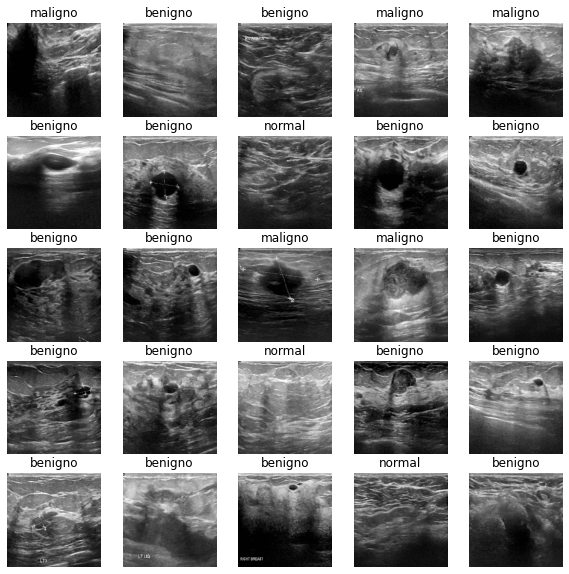

In [38]:
# Plotar as imagens em uma grade de Gráficos

# Definindo o tamanho da Grade
Figuras, Eixos = plt.subplots(5, 5, figsize=(10,10) )
# Transformar uma matriz em um vetor
Eixos = Eixos.ravel()

# Loop pra plotar as imagens
for Loop in np.arange(0,25):
    
    # Plotando as imagens no gráfico
    Eixos[Loop].imshow( Imagens_Treino[Loop] )
    
    # Colocando o Titulo nas Imanges
    Eixos[Loop].set_title( Classes[ np.argmax( Classe_Treino[Loop] ) ] )
    
    # Retirando o eixo da escala
    Eixos[Loop].axis('off')
    
# Colocar um espaço entre as imagens
plt.subplots_adjust( wspace=0.2 )

In [39]:
# Criando a rede neural convolucional com uma estrutura pré-treinada
Modelo_Basico = ResNet50( 
    # Definindo o treino
    weights='imagenet',
    
    # Definindo False para podemos criar a estrutura da rede
    include_top=False,
    
    # Definindo o formato de entrada dos dados
    input_tensor= Input( shape=(256,256, 3) )
)

In [40]:
# Verificando os dados da Rede Neural
Modelo_Basico.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [41]:
# Verificando as camadas da Rede
len( Modelo_Basico.layers )

175

In [42]:
# Congelando os pesos da Rede Neural
# Vamos deixar as ultimas camdas livres para serem treinadas
for Camada in Modelo_Basico.layers[:-10]:
    # Cancelando o ajuste dos pesos
    Camada.trainable = False

In [43]:
# Definindo a camada de inicio
Modelo_Inicio = Modelo_Basico.output

# Reduzindo as deminensão
Modelo_Inicio = AveragePooling2D()( Modelo_Inicio )

# Adicionando uma camada
Modelo_Inicio = Flatten()( Modelo_Inicio )

# Adicionando os neuronoios -- 1º
Modelo_Inicio = Dense( 256, activation='relu')( Modelo_Inicio )

# Adicionando o Dropout para zerar os neuronios e evitar overfiting
Modelo_Inicio = Dropout(0.2)( Modelo_Inicio )

# Adicionando os neuronoios -- 2º
Modelo_Inicio = Dense( 256, activation='relu')( Modelo_Inicio )

# Adicionando o Dropout para zerar os neuronios e evitar overfiting
Modelo_Inicio = Dropout(0.2)( Modelo_Inicio )

# Definindo os neuronios de saida
Modelo_Inicio = Dense(3, activation='softmax')( Modelo_Inicio )

In [51]:
# Criando o Modelo da Rede Neural
Modelo = Model( inputs=Modelo_Basico.input, outputs=Modelo_Inicio )

# Configurando alguns paramentros da Rede
Modelo.compile( 
    # Função de Erro 
    loss='categorical_crossentropy',
    
    # Algoritimo de ajustes dos Pesos
    optimizer=optimizers.RMSprop( lr=1e-4, decay=1e-6),
    
    # Metrica de avaliação
    metrics=['accuracy']
)

In [52]:
# Treinamento da Rede Neural

# Salvar os dados da Rede Neural
Salvando_Rede = ModelCheckpoint( filepath='weigts.hdf5', save_best_only=True)

# Função para acessar as imagens do diretorio e preparar as imagens
Treino_Generator = Image_Generator.flow_from_directory(
    # Definindo um batch para rodar 50 imagens
    batch_size=20,
    
    # Passando o local das imagens
    directory=Diretorio_Imagens,
    
    # Habilitando a opção para embalharar as imagens
    shuffle=True,
    
    # Definindo o tamanho da imagem
    target_size=(256,256),
    
    # Definindo um problema de classificação
    class_mode='categorical',
    
    # Definindo como base de treino
    subset='training',
)

Found 780 images belonging to 3 classes.


In [53]:
# Rodar o Modelo
Historico = Modelo.fit_generator( 
    # Passando o Treino Generator
    Treino_Generator, 
    
    # Definindo as epocas - bacthes
    epochs=30, 
    
    # Definido para salvar os pesos da Redes
    callbacks=[Salvando_Rede]
)

# --------------- Isso vai demorar !!!!!!!!!!!!!!! --------------- #

Epoch 1/30
39/39 [==============================] - 142s 4s/step - loss: 0.7389 - accuracy: 0.6692
Epoch 2/30
39/39 [==============================] - 144s 4s/step - loss: 0.6365 - accuracy: 0.7077
Epoch 3/30
39/39 [==============================] - 143s 4s/step - loss: 0.6110 - accuracy: 0.7256
Epoch 4/30
39/39 [==============================] - 147s 4s/step - loss: 0.5834 - accuracy: 0.7603
Epoch 5/30
39/39 [==============================] - 146s 4s/step - loss: 0.5733 - accuracy: 0.7564
Epoch 6/30
39/39 [==============================] - 142s 4s/step - loss: 0.6032 - accuracy: 0.7474
Epoch 7/30
39/39 [==============================] - 142s 4s/step - loss: 0.5575 - accuracy: 0.7462
Epoch 8/30
39/39 [==============================] - 141s 4s/step - loss: 0.5513 - accuracy: 0.7462
Epoch 9/30
39/39 [==============================] - 142s 4s/step - loss: 0.5208 - accuracy: 0.7744
Epoch 10/30
39/39 [==============================] - 149s 4s/step - loss: 0.5106 - accuracy: 0.7731
Epoch 11/

In [54]:
# Acessando os dados da Rede
Historico.history.keys()

dict_keys(['loss', 'accuracy'])

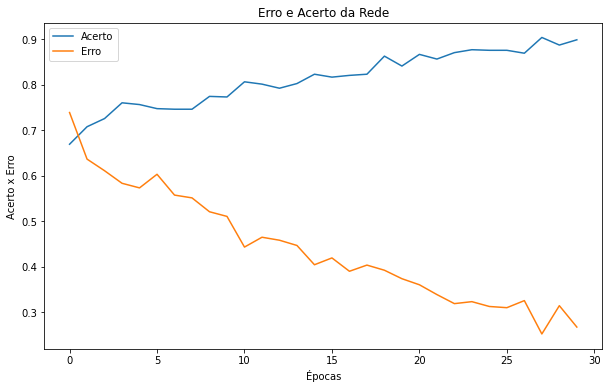

In [55]:
# Plotar a Acuracia do Modelo

# Definindo uma figura
plt.figure( figsize=(10,6) )
# Plotando a Acuracia
plt.plot( Historico.history['accuracy'] )
# Plotando o erro
plt.plot( Historico.history['loss'] )
# Definindo o Tituli
plt.title('Erro e Acerto da Rede')
# Definindo os Labels
plt.xlabel('Épocas')
plt.ylabel('Acerto x Erro')
# Definindo a Legenda
plt.legend(['Acerto', 'Erro']);

In [56]:
Historico.history['accuracy']

[0.6692307591438293,
 0.7076923251152039,
 0.7256410121917725,
 0.7602564096450806,
 0.7564102411270142,
 0.7474358677864075,
 0.7461538314819336,
 0.7461538314819336,
 0.7743589878082275,
 0.7730769515037537,
 0.8064102530479431,
 0.8012820482254028,
 0.7923076748847961,
 0.8025640845298767,
 0.8230769038200378,
 0.8166666626930237,
 0.8205128312110901,
 0.8230769038200378,
 0.8628205060958862,
 0.8410256505012512,
 0.8666666746139526,
 0.8564102649688721,
 0.870512843132019,
 0.8769230842590332,
 0.8756410479545593,
 0.8756410479545593,
 0.8692307472229004,
 0.9038461446762085,
 0.8871794939041138,
 0.8987179398536682]

In [57]:
Historico.history['loss']

[0.7388902902603149,
 0.6365159749984741,
 0.6110117435455322,
 0.5833893418312073,
 0.5732858777046204,
 0.6031924486160278,
 0.5574621558189392,
 0.5513250231742859,
 0.5208374857902527,
 0.5106241703033447,
 0.44322702288627625,
 0.46484753489494324,
 0.45829012989997864,
 0.44676142930984497,
 0.4043913185596466,
 0.4193735718727112,
 0.3900572657585144,
 0.4036119878292084,
 0.39233314990997314,
 0.3737051486968994,
 0.360387921333313,
 0.33886584639549255,
 0.31894925236701965,
 0.3232702910900116,
 0.3126790225505829,
 0.31002992391586304,
 0.32555970549583435,
 0.25225672125816345,
 0.31443431973457336,
 0.2674611508846283]